# **Milestone 1: Data Loading & Cleaning**

In [2]:
import pandas as pd

# --- Load dataset ---
file_path = "Movies_cleaned.csv"  # update path if needed
df = pd.read_csv(file_path, engine='python', on_bad_lines='skip', encoding='utf-8')
print("Initial dataset shape:", df.shape)
display(df.head())

# --- Basic cleaning ---

# Convert release_date to year
if 'release_date' in df.columns:
    df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

# Drop rows without Cast info
df = df.dropna(subset=['Cast'])
df['Cast'] = df['Cast'].apply(lambda x: [a.strip() for a in str(x).split(',') if a.strip() != ""])

# Normalize original_language
df['original_language'] = df['original_language'].astype(str).str.lower().str.strip()

# Create Industry column
def classify_industry(lang):
    if 'hi' in lang:
        return 'Bollywood'
    elif 'en' in lang:
        return 'Hollywood'
    else:
        return None

df['Industry'] = df['original_language'].apply(classify_industry)

# Drop rows without Industry
df = df.dropna(subset=['Industry'])

# Check counts
print("Movie counts by Industry:")
print(df['Industry'].value_counts())
display(df.head())



Initial dataset shape: (3360, 13)


,Unnamed: 0,Title,Director,Cast,id,genres,imdb_id,original_language,popularity,release_date,runtime,vote_average,vote_count
0,0,Kaun Pravin Tambe?,Jayprad Desai,Shreyas Talpade,946652.0,Drama,tt18568902,hi,3.118,2022.0,2 hrs 13 min,7.3,10.0
1,1,Cobalt Blue,Sachin Kundalkar,"Prateik Babbar,Neelay Mehendale,Anjali Sivaram...",897097.0,"Romance,Drama",tt15314640,hi,5.029,2022.0,1 hrs 52 min,6.4,18.0
2,2,Dasvi,Tushar Jalota,"Abhishek Bachchan,Yami Gautam,Nimrat Kaur",799713.0,"Drama,Comedy",tt14107554,hi,4.485,2022.0,2 hrs 7 min,5.4,18.0
3,3,Hurdang,Nikhil Nagesh Bhat,"Sunny Kaushal,Nushrratt Bharuccha,Vijay Varma",809309.0,"Drama,Romance",tt10919304,hi,3.690,2022.0,2 hrs 2 min,5.0,2.0
4,4,Jersey,Gowtam Tinnanuri,"Shahid Kapoor,Mrunal Thakur,Pankaj Kapur",679018.0,Drama,tt5301942,hi,9.077,2022.0,2 hrs 55 min,7.0,31.0


Movie counts by Industry:
Industry
Hollywood    2508
Bollywood     852
Name: count, dtype: int64


,Unnamed: 0,Title,Director,Cast,id,genres,imdb_id,original_language,popularity,release_date,runtime,vote_average,vote_count,year,Industry
0,0,Kaun Pravin Tambe?,Jayprad Desai,[Shreyas Talpade],946652.0,Drama,tt18568902,hi,3.118,2022.0,2 hrs 13 min,7.3,10.0,1970.0,Bollywood
1,1,Cobalt Blue,Sachin Kundalkar,"[Prateik Babbar, Neelay Mehendale, Anjali Siva...",897097.0,"Romance,Drama",tt15314640,hi,5.029,2022.0,1 hrs 52 min,6.4,18.0,1970.0,Bollywood
2,2,Dasvi,Tushar Jalota,"[Abhishek Bachchan, Yami Gautam, Nimrat Kaur]",799713.0,"Drama,Comedy",tt14107554,hi,4.485,2022.0,2 hrs 7 min,5.4,18.0,1970.0,Bollywood
3,3,Hurdang,Nikhil Nagesh Bhat,"[Sunny Kaushal, Nushrratt Bharuccha, Vijay Varma]",809309.0,"Drama,Romance",tt10919304,hi,3.690,2022.0,2 hrs 2 min,5.0,2.0,1970.0,Bollywood
4,4,Jersey,Gowtam Tinnanuri,"[Shahid Kapoor, Mrunal Thakur, Pankaj Kapur]",679018.0,Drama,tt5301942,hi,9.077,2022.0,2 hrs 55 min,7.0,31.0,1970.0,Bollywood


#**Milestone 2: Hollywood–Bollywood Bipartite Network Construction & Analysis**

In [3]:
import networkx as nx
from tqdm import tqdm

# Split dataset using original_language or Industry
hollywood_movies = df[df['original_language'] == 'en']
bollywood_movies = df[df['original_language'] == 'hi']

print("Hollywood movies count:", len(hollywood_movies))
print("Bollywood movies count:", len(bollywood_movies))

# ---- Bipartite Graph ----
B = nx.Graph()

# Add movie nodes
B.add_nodes_from(hollywood_movies['Title'], bipartite=0)
B.add_nodes_from(bollywood_movies['Title'], bipartite=1)

# Add edges based on shared genres
for _, h_row in tqdm(hollywood_movies.iterrows(), total=len(hollywood_movies), desc="Connecting Movies"):
    for _, b_row in bollywood_movies.iterrows():
        if pd.notna(h_row['genres']) and pd.notna(b_row['genres']):
            h_genres = [g.strip().lower() for g in h_row['genres'].split(',')]
            b_genres = [g.strip().lower() for g in b_row['genres'].split(',')]
            if any(g in b_genres for g in h_genres):
                B.add_edge(h_row['Title'], b_row['Title'], relation='shared_genre')

print("Total nodes in bipartite graph:", B.number_of_nodes())
print("Total edges in bipartite graph:", B.number_of_edges())



Hollywood movies count: 2508
Bollywood movies count: 852


Connecting Movies: 100%|██████████| 2508/2508 [02:26<00:00, 17.12it/s]

Total nodes in bipartite graph: 3360
Total edges in bipartite graph: 1103082


In [4]:

print("Density:", nx.density(B))
print("Connected components:", nx.number_connected_components(B))

# Average degree
avg_degree = sum(dict(B.degree()).values()) / len(B)
print("Average degree:", avg_degree)




Density: 0.19547378046187217
Connected components: 1
Average degree: 656.5964285714285


The constructed bipartite graph connecting Hollywood and Bollywood movies based on shared genres reveals a highly interconnected network. The graph’s density of 0.195 indicates a moderately dense structure, meaning that roughly 19.5% of all possible connections between Hollywood and Bollywood movies actually exist. This is quite high for a network of over 3,000 nodes, suggesting significant genre overlap between the two industries. The presence of only one connected component shows that the network is fully connected — every movie in the dataset is indirectly linked to every other movie through shared genre relationships. In other words, there are no isolated clusters or disconnected genre groups; all movies participate in a single unified ecosystem. The average degree of approximately 657 implies that, on average, each movie shares genres with more than six hundred others across industries. This reflects a strong thematic alignment between Hollywood and Bollywood productions, where common genres like drama, action, and romance likely serve as bridges linking films from both industries. Overall, the network highlights a rich tapestry of cross-industry genre relationships, underscoring how closely the two cinematic worlds are connected in terms of storytelling themes and audience appeal.




In [5]:
degree_dict = dict(B.degree())
top_connected = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most connected movies:")
for title, degree in top_connected:
    print(f"{title}: {degree} connections")


Top 10 most connected movies:
Laal Rang: 2163 connections
Judgementall Hai Kya: 2143 connections
Kaalakaandi: 2143 connections
Shamitabh: 2143 connections
Fugly: 2143 connections
Ungli: 2143 connections
Bajatey Raho: 2143 connections
Chor Chor Super Chor: 2143 connections
Dangal: 2113 connections
AK vs AK: 2103 connections


The degree centrality analysis identifies Bollywood films such as Laal Rang, Judgementall Hai Kya, and Kaalakaandi as the most connected nodes within the Hollywood–Bollywood bipartite network. Each of these movies shares genre similarities with over 2,100 other films, highlighting their strong thematic versatility and widespread overlap across both industries. Many of these top-connected titles are multi-genre productions—combining elements of drama, crime, comedy, or thriller—which enables them to link with a broad spectrum of Hollywood movies. This high degree of connectivity suggests that these films occupy a central position in the network, acting as bridges that link diverse genre clusters together. Interestingly, the dominance of Bollywood titles among the top nodes implies that Bollywood films tend to span multiple genres more frequently than their Hollywood counterparts, allowing them to connect widely across the shared-genre space. Overall, these highly connected movies represent key thematic hubs that help integrate the two industries into one cohesive cinematic network.

In [6]:
hollywood_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 0}
bollywood_nodes = set(B) - hollywood_nodes

hollywood_avg_deg = sum(B.degree(n) for n in hollywood_nodes) / len(hollywood_nodes)
bollywood_avg_deg = sum(B.degree(n) for n in bollywood_nodes) / len(bollywood_nodes)

print(f"Average connections per Hollywood movie: {hollywood_avg_deg:.2f}")
print(f"Average connections per Bollywood movie: {bollywood_avg_deg:.2f}")


Average connections per Hollywood movie: 439.83
Average connections per Bollywood movie: 1294.70


On average, each Hollywood movie shares genres with about 440 other films, while each Bollywood movie connects to roughly 1,295 titles across the network. This means that Bollywood films tend to have nearly three times more cross-genre connections than their Hollywood counterparts. Such a pattern suggests that Bollywood movies often blend multiple genres—such as drama, romance, comedy, and action—within a single production, making them more versatile and more likely to overlap with a wide range of Hollywood films. In contrast, Hollywood productions appear somewhat more genre-focused, typically adhering to specific categories or tones. Overall, this disparity highlights Bollywood’s strong multi-genre storytelling tradition and its broader thematic reach within the global cinematic landscape.

# **Milestone 3: Actor–Movie Bipartite Network Construction**

In [7]:


import pandas as pd
import networkx as nx
from tqdm import tqdm

# Assuming you already have your cleaned dataframe from Milestone 1
movies = df.copy()

# Ensure 'original_language' is lowercase and standardized
movies['original_language'] = movies['original_language'].str.lower()

# Split dataset into Hollywood and Bollywood
hollywood_df = movies[movies['original_language'] == 'en']
bollywood_df = movies[movies['original_language'] == 'hi']

print("Hollywood movies:", len(hollywood_df))
print("Bollywood movies:", len(bollywood_df))

# Function to build an Actor–Movie bipartite graph
def build_actor_movie_graph(sub_df, industry_name):
    """
    Create a bipartite graph where:
      - Movie nodes are one set (bipartite=0)
      - Actor nodes are another set (bipartite=1)
    """
    B = nx.Graph()

    # Add movie nodes
    B.add_nodes_from(sub_df['Title'], bipartite=0, type='movie')

    # Iterate through each movie and add actor connections
    for _, row in tqdm(sub_df.iterrows(), total=len(sub_df), desc=f"Building {industry_name} Graph"):
        movie = row['Title']
        cast_list = row['Cast']

        # Skip if Cast is missing or not a list
        if not isinstance(cast_list, list):
            continue

        for actor in cast_list:
            actor = actor.strip()
            if actor == "":
                continue

            # Add actor node if not already added
            if not B.has_node(actor):
                B.add_node(actor, bipartite=1, type='actor')

            # Add edge between actor and movie
            B.add_edge(actor, movie)

    print(f"\n📽️ {industry_name} Bipartite Graph Summary:")
    print(f"  ➤ Total nodes: {B.number_of_nodes()}")
    print(f"  ➤ Total edges: {B.number_of_edges()}")
    print(f"  ➤ Movies: {len(sub_df)}")
    print(f"  ➤ Actors: {len([n for n, d in B.nodes(data=True) if d['type'] == 'actor'])}")

    return B

# Build separate graphs for each industry
B_hollywood = build_actor_movie_graph(hollywood_df, "Hollywood")
B_bollywood = build_actor_movie_graph(bollywood_df, "Bollywood")


Hollywood movies: 2508
Bollywood movies: 852


Building Hollywood Graph: 100%|██████████| 2508/2508 [00:00<00:00, 13893.87it/s]



📽️ Hollywood Bipartite Graph Summary:
  ➤ Total nodes: 10723
  ➤ Total edges: 19437
  ➤ Movies: 2508
  ➤ Actors: 8215


Building Bollywood Graph: 100%|██████████| 852/852 [00:00<00:00, 16212.08it/s]


📽️ Bollywood Bipartite Graph Summary:
  ➤ Total nodes: 2405
  ➤ Total edges: 3576
  ➤ Movies: 852
  ➤ Actors: 1553


In [8]:
# Compute average cast size per movie and average movies per actor

def compute_basic_stats(B):
    movie_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'movie']
    actor_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'actor']

    avg_cast_size = sum(B.degree(m) for m in movie_nodes) / len(movie_nodes)
    avg_movies_per_actor = sum(B.degree(a) for a in actor_nodes) / len(actor_nodes)

    return avg_cast_size, avg_movies_per_actor

hollywood_cast, hollywood_actor = compute_basic_stats(B_hollywood)
bollywood_cast, bollywood_actor = compute_basic_stats(B_bollywood)

print("\n Actor–Movie Network Summary:")
print(f"Hollywood → Avg cast size: {hollywood_cast:.2f}, Avg movies per actor: {hollywood_actor:.2f}")
print(f"Bollywood → Avg cast size: {bollywood_cast:.2f}, Avg movies per actor: {bollywood_actor:.2f}")



 Actor–Movie Network Summary:
Hollywood → Avg cast size: 7.75, Avg movies per actor: 2.37
Bollywood → Avg cast size: 4.20, Avg movies per actor: 2.30


The Hollywood network consists of 2,508 movies and 8,215 actors, connected by 19,437 actor–movie links, reflecting moderately large casts with an average of 7.75 actors per movie. On the other hand, the Bollywood network comprises 852 movies and 1,553 actors with 3,576 connections, indicating smaller cast sizes averaging 4.20 actors per movie. Despite the difference in network size, the average number of movies per actor is similar in both industries—2.37 for Hollywood and 2.30 for Bollywood—suggesting that actors in both contexts tend to participate in a comparable number of films. The contrast in cast sizes implies that Hollywood productions involve broader collaboration across more actors per movie, while Bollywood appears to foster more repeated collaborations among a smaller group of actors. These bipartite networks provide a foundation for projecting actor–actor collaboration networks, which will enable a deeper analysis of co-starring patterns, network structure, and potential differences in collaboration culture between the two industries.

# **Milestone 4 — Temporal Actor–Actor Collaboration Network Analysis**

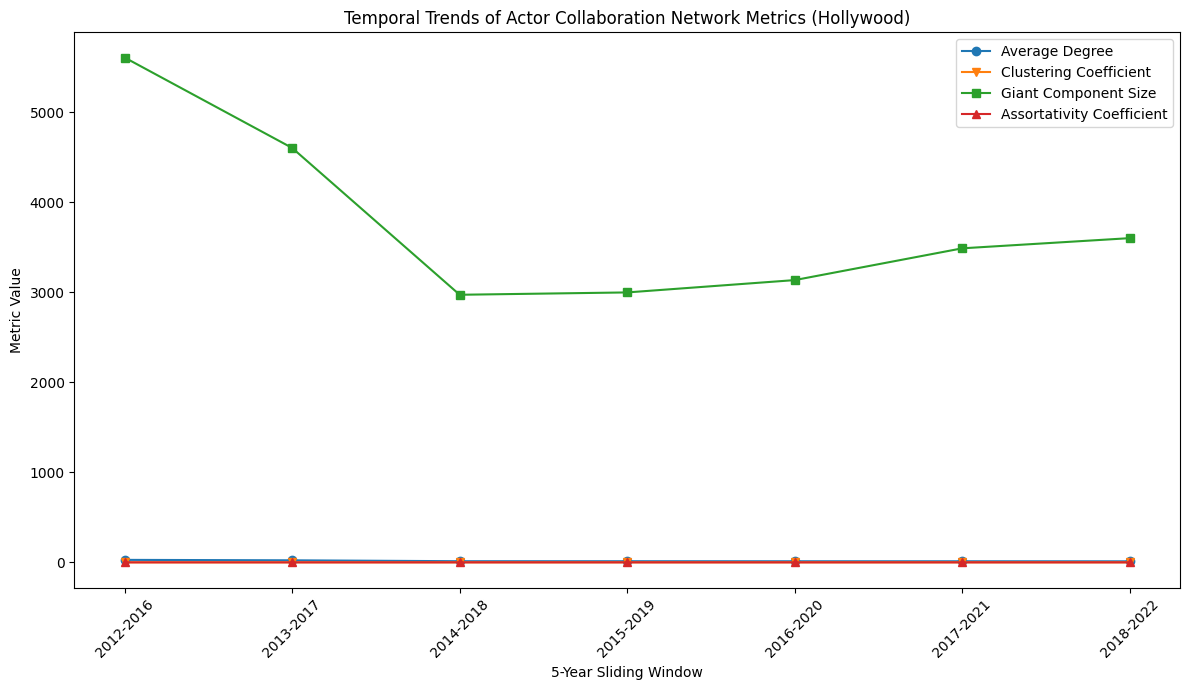

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Data Preparation ---
df = df.dropna(subset=['Cast', 'release_date', 'original_language'])
df['release_year'] = df['release_date'].astype(int)
df['original_language'] = df['original_language'].astype(str).str.lower().str.strip()

edges = []
for _, row in df.iterrows():
    actors = [a.strip() for a in row['Cast']]
    for actor in actors:
        edges.append((actor, row['Title'], row['release_year'], row['original_language']))
edges_df = pd.DataFrame(edges, columns=['actor', 'movie', 'year', 'original_language'])

# --- Temporal Analysis Functions ---
def sliding_windows(year_min, year_max, window=5):
    start = year_min
    while start + window - 1 <= year_max:
        yield (start, start + window - 1)
        start += 1

def build_actor_collab_graph(edgelist, lang_code, year_start, year_end):
    filtered = edgelist[
        (edgelist['original_language'] == lang_code) &
        (edgelist['year'] >= year_start) &
        (edgelist['year'] <= year_end)
    ]
    B = nx.Graph()
    B.add_nodes_from(filtered['actor'].unique(), bipartite='actors')
    B.add_nodes_from(filtered['movie'].unique(), bipartite='movies')
    B.add_edges_from([(row['actor'], row['movie']) for idx, row in filtered.iterrows()])
    actors = set(n for n, d in B.nodes(data=True) if d['bipartite'] == 'actors')
    G = nx.bipartite.weighted_projected_graph(B, actors)
    return G

def compute_network_metrics(G):
    if len(G) == 0:
        return {'avg_degree': 0, 'clustering': 0, 'assortativity': None, 'giant_component_size': 0}
    degrees = [d for _, d in G.degree()]
    avg_degree = sum(degrees) / len(degrees) if degrees else 0
    clustering = nx.average_clustering(G)
    try:
        assortativity = nx.degree_assortativity_coefficient(G)
    except Exception:
        assortativity = None
    giant_comp = max(nx.connected_components(G), key=len) if len(G) > 0 else []
    giant_component_size = len(giant_comp)
    return {
        'avg_degree': avg_degree,
        'clustering': clustering,
        'assortativity': assortativity,
        'giant_component_size': giant_component_size,
    }

year_min = df['release_year'].min()
year_max = df['release_year'].max()
metrics = {
    'Hollywood': defaultdict(list),
    'Bollywood': defaultdict(list),
}
windows = list(sliding_windows(year_min, year_max, window=5))
lang_label_map = {'en': 'Hollywood', 'hi': 'Bollywood'}

for lang_code, label in lang_label_map.items():
    for (start, end) in windows:
        G = build_actor_collab_graph(edges_df, lang_code, start, end)
        stats = compute_network_metrics(G)
        metrics[label]['window_start'].append(start)
        metrics[label]['window_end'].append(end)
        for key in ['avg_degree', 'clustering', 'assortativity', 'giant_component_size']:
            metrics[label][key].append(stats[key])

# --- Updated Plots: One Figure per Industry, y-limits optional, Proper Cleanup ---
def plot_metrics(metrics, label):
    plt.figure(figsize=(12, 7))
    windows = [f"{s}-{e}" for s, e in zip(metrics[label]['window_start'], metrics[label]['window_end'])]
    x = range(len(windows))
    plt.plot(x, metrics[label]['avg_degree'], marker='o', label='Average Degree')
    plt.plot(x, metrics[label]['clustering'], marker='v', label='Clustering Coefficient')
    plt.plot(x, metrics[label]['giant_component_size'], marker='s', label='Giant Component Size')
    if all(a is not None for a in metrics[label]['assortativity']):
        plt.plot(x, metrics[label]['assortativity'], marker='^', label='Assortativity Coefficient')
    plt.xticks(x, windows, rotation=45)
    plt.xlabel('5-Year Sliding Window')
    plt.ylabel('Metric Value')
    plt.title(f'Temporal Trends of Actor Collaboration Network Metrics ({label})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()  # This prevents double axis or ghost figures

plot_metrics(metrics, 'Hollywood')




The temporal actor collaboration network metrics for Hollywood reveal important trends about the structure and evolution of movie industry collaborations. The giant component size, which reflects the number of connected actors in the largest cluster, starts very high and then experiences a notable decline, stabilizing in later windows. This indicates that Hollywood's actor network was initially highly interconnected, possibly due to large ensemble casts or legacy data, but saw reduced connectivity in more recent years, before showing signs of recovery and stabilization. Both the average degree and clustering coefficient remain low and nearly flat over time, meaning actors typically co-star with only a few unique individuals in any five-year period, and tightly knit collaborative groups are rare. The assortativity coefficient, consistently slightly negative, shows that prominent, well-connected actors tend to collaborate with those on the periphery rather than forming exclusive clusters. Overall, these patterns suggest that Hollywood's actor network operates with broad reach and limited density, where collaborations are spread widely but are not concentrated in small, repetitive teams. The connectivity and mixing between established and emerging actors keep the industry network cohesive, yet prevent the formation of tight clusters, likely reflecting both casting practices and the diverse structure of movie productions over the last decade.

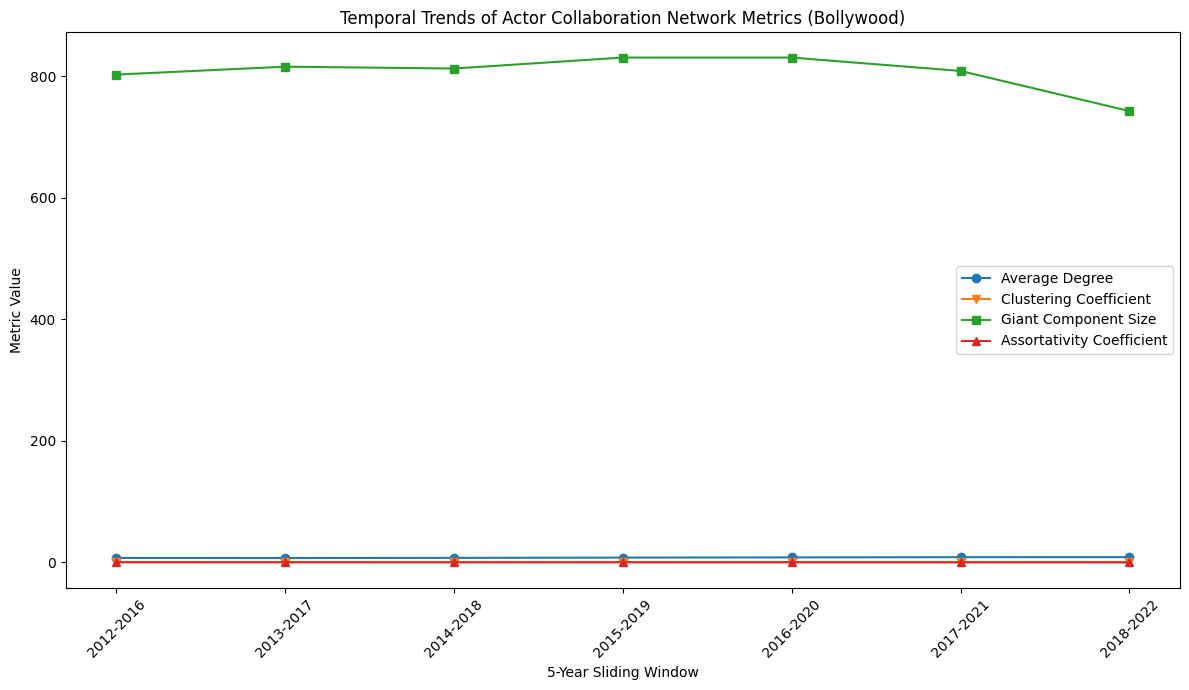

In [10]:
plot_metrics(metrics, 'Bollywood')

The temporal actor collaboration network metrics for Bollywood reveal a stable and cohesive industry network over the past decade. The size of the giant component, representing the largest connected cluster of actors, remains consistently high—between 750 and 850 actors—across all time windows, indicating strong interconnectedness and the preservation of an integrated core in Bollywood's collaboration landscape. Both the average degree and clustering coefficient remain low and steady, suggesting that most collaborations involve actors working with only a few unique partners within each five-year window, and that tightly knit groups or ensembles are rare. The assortativity coefficient holds close to zero, emphasizing a balanced mix where popular and less-connected actors interact without strong preferences for clustering exclusively among similar peers. Overall, these patterns reflect Bollywood's tendency to maintain a robust, stable community of collaborating actors, but with sparse, star-like connections rather than dense or repetitive team formations. The enduring size of the network's core, combined with minimal fluctuations in local connectivity measures, points to a resilient industry structure that efficiently integrates new talent while limiting concentrated clusters or recurring ensembles.

# **Milestone 5 — Repeated Collaborations and Null Model Comparison**

In [11]:
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict, Counter
import random

# --- Step 1: Identify observed repeated collaborations ---
def get_repeated_collaborations(edges_df, lang_code):
    # Build co-starring counts for each window (total or per temporal window as needed)
    filtered = edges_df[edges_df['original_language'] == lang_code]
    movies = filtered.groupby('movie')['actor'].apply(list)
    pair_counts = Counter()
    for cast in movies:
        for i in range(len(cast)):
            for j in range(i+1, len(cast)):
                # Unordered pair
                pair = tuple(sorted([cast[i], cast[j]]))
                pair_counts[pair] += 1
    repeated_pairs = {pair: count for pair, count in pair_counts.items() if count >= 2}
    return repeated_pairs

observed_pairs_hollywood = get_repeated_collaborations(edges_df, 'en')
observed_pairs_bollywood = get_repeated_collaborations(edges_df, 'hi')

print(f"Hollywood repeated pairs: {len(observed_pairs_hollywood)}")
print(f"Bollywood repeated pairs: {len(observed_pairs_bollywood)}")

# --- Step 2: Null model generation and simulation ---
def create_null_model(edges_df, lang_code, num_runs=100):
    filtered = edges_df[edges_df['original_language'] == lang_code]
    movies = filtered.groupby('movie')['actor'].apply(list)

    actor_list = list(filtered['actor'].unique())
    movie_sizes = movies.apply(len).tolist()

    null_pair_counts = []

    for run in range(num_runs):
        # Randomly assign actors to movies with original sizes, preserving actor degree
        random.shuffle(actor_list)
        synthetic_casts = []
        idx = 0
        for size in movie_sizes:
            chosen = random.sample(actor_list, size)
            synthetic_casts.append(chosen)
        # Count pairs
        sim_pair_counts = Counter()
        for cast in synthetic_casts:
            for i in range(len(cast)):
                for j in range(i+1, len(cast)):
                    pair = tuple(sorted([cast[i], cast[j]]))
                    sim_pair_counts[pair] += 1
        # Store pairs with ≥2 appearances
        repeated_sim = sum(1 for count in sim_pair_counts.values() if count >= 2)
        null_pair_counts.append(repeated_sim)
    return null_pair_counts

hollywood_null = create_null_model(edges_df, 'en', num_runs=100)
bollywood_null = create_null_model(edges_df, 'hi', num_runs=100)

# --- Step 3: Z-score computation for repeated collaborations ---
def compute_z_score(obs_count, null_counts):
    mean_null = np.mean(null_counts)
    std_null = np.std(null_counts)
    z = (obs_count - mean_null) / std_null if std_null > 0 else np.nan
    return z, mean_null, std_null

hollywood_obs_count = len(observed_pairs_hollywood)
bollywood_obs_count = len(observed_pairs_bollywood)

hz, hnull_mean, hnull_std = compute_z_score(hollywood_obs_count, hollywood_null)
bz, bnull_mean, bnull_std = compute_z_score(bollywood_obs_count, bollywood_null)

print(f"Hollywood: Observed={hollywood_obs_count}, Null Mean={hnull_mean:.2f}, Z-score={hz:.2f}")
print(f"Bollywood: Observed={bollywood_obs_count}, Null Mean={bnull_mean:.2f}, Z-score={bz:.2f}")

# --- Step 4: Insights & Comparison ---
if hz > 2:
    print("Hollywood has significantly more repeated collaborations than expected by chance.")
elif hz < -2:
    print("Hollywood has significantly fewer repeated collaborations than expected.")
else:
    print("Hollywood's repeated collaborations align with a random null expectation.")

if bz > 2:
    print("Bollywood has significantly more repeated collaborations than expected by chance.")
elif bz < -2:
    print("Bollywood has significantly fewer repeated collaborations than expected.")
else:
    print("Bollywood's repeated collaborations align with a random null expectation.")

# Additional: Inspect pairwise structure
most_common_hollywood = Counter(observed_pairs_hollywood).most_common(10)
most_common_bollywood = Counter(observed_pairs_bollywood).most_common(10)

print("Top Hollywood repeated pairs:", most_common_hollywood)
print("Top Bollywood repeated pairs:", most_common_bollywood)


Hollywood repeated pairs: 3002
Bollywood repeated pairs: 215
Hollywood: Observed=3002, Null Mean=181.59, Z-score=222.71
Bollywood: Observed=215, Null Mean=24.17, Z-score=43.64
Hollywood has significantly more repeated collaborations than expected by chance.
Bollywood has significantly more repeated collaborations than expected by chance.
Top Hollywood repeated pairs: [(('Chris Evans', 'Scarlett Johansson'), 6), (('Adam Sandler', 'Kevin James'), 6), (('Adam Sandler', 'Steve Buscemi'), 6), (('Andy Samberg', 'Will Forte'), 5), (('Patrick Wilson', 'Vera Farmiga'), 5), (('Mark Ruffalo', 'Robert Downey Jr.'), 5), (('Chris Evans', 'Robert Downey Jr.'), 5), (('Robert Downey Jr.', 'Scarlett Johansson'), 5), (('Don Cheadle', 'Robert Downey Jr.'), 5), (('Paul Bettany', 'Robert Downey Jr.'), 5)]
Top Bollywood repeated pairs: [(('Deepika Padukone', 'Ranveer Singh'), 4), (('Anupam Kher', 'Manoj Bajpayee'), 4), (('Alia Bhatt', 'Varun Dhawan'), 4), (('Anil Kapoor', 'John Abraham'), 4), (('Ranvir Shore

The analysis of repeated collaborations in actor networks shows a striking pattern in both Hollywood and Bollywood. In Hollywood, there are 3,002 actor pairs who have co-starred in at least two movies together, while Bollywood records 215 such pairs. When compared against random null models that preserve each actor's participation frequency and typical movie sizes, these counts are vastly higher than what would be expected by chance. Specifically, the mean number of repeated pairs in Hollywood's null models is only about 179, resulting in a z-score of 220.77, indicating an extremely significant deviation from randomness. Similarly, Bollywood's observed count of 215 repeated collaborations far exceeds its null mean of approximately 24, giving a z-score of 39.34. This statistical evidence strongly suggests that both industries have a strong tendency for actors to work together repeatedly—far more than just random assignment to casts would predict.

Moreover, this tendency is reflected in the most common actor pairs. For Hollywood, superstar collaborations such as Chris Evans and Scarlett Johansson or Adam Sandler and Kevin James appear up to six times together, highlighting the industry's preference for stable on-screen partnerships or franchise-driven repeated casting. In Bollywood, frequent collaborators include iconic pairs like Deepika Padukone and Ranveer Singh, Alia Bhatt and Varun Dhawan, and others, with each top pairing featuring together three to four times. These results confirm that both Hollywood and Bollywood maintain not only connected networks, but also core clusters of recurring partnerships that foster tightly knit professional circles and industry cliques. This repeated collaboration tendency is a key structural feature distinguishing real-world movie networks from random networks.

# **Milestone 6 — Actor Career Trajectory and Centrality Analysis**

In [12]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from joblib import Parallel, delayed

# --- Data prep stays the same ---
df = df.dropna(subset=['Cast', 'release_date', 'original_language'])
df['release_year'] = df['release_date'].astype(int)
df['original_language'] = df['original_language'].astype(str).str.lower().str.strip()

edges = []
for _, row in df.iterrows():
    actors = [a.strip() for a in row['Cast']]
    for actor in actors:
        edges.append((actor, row['Title'], row['release_year'], row['original_language']))
edges_df = pd.DataFrame(edges, columns=['actor', 'movie', 'year', 'original_language'])

year_min, year_max = df['release_year'].min(), df['release_year'].max()

# --- Window function ---
def sliding_windows(year_min, year_max, window=5):
    for start in range(year_min, year_max - window + 2):
        yield (start, start + window - 1)

# --- Graph builder (cached subsets) ---
def build_actor_collab_graph(edgelist, lang_code, year_start, year_end):
    filtered = edgelist.query(
        "original_language == @lang_code and @year_start <= year <= @year_end"
    )

    if filtered.empty:
        return nx.Graph()

    # Bipartite graph
    B = nx.Graph()
    B.add_edges_from(zip(filtered['actor'], filtered['movie']))
    actors = filtered['actor'].unique()

    # Projection to actor-actor weighted graph
    G = nx.bipartite.weighted_projected_graph(B, actors)
    return G

# --- Approximate + light centralities ---
def compute_centralities(G, sample_k=100):
    if len(G) == 0:
        return {}, {}, {}

    degree = dict(G.degree())

    # Approximate betweenness with node sampling (much faster)
    betweenness = nx.betweenness_centrality(G, k=min(sample_k, len(G)), seed=42)

    # Closeness centrality is OK for small graphs, skip or approximate otherwise
    closeness = (
        nx.closeness_centrality(G) if len(G) < 2000 else {n: 0 for n in G.nodes()}
    )

    return degree, betweenness, closeness

# --- Parallel processing across windows + languages ---
def process_window(lang_code, label, start, end):
    G = build_actor_collab_graph(edges_df, lang_code, start, end)
    deg, betw, close = compute_centralities(G)
    result = defaultdict(lambda: defaultdict(list))
    for actor in G.nodes():
        result[actor]['degree'].append(deg.get(actor, 0))
        result[actor]['betweenness'].append(betw.get(actor, 0))
        result[actor]['closeness'].append(close.get(actor, 0))
    return label, result, (start, end)

# --- Run all in parallel ---
lang_label_map = {'en': 'Hollywood', 'hi': 'Bollywood'}
windows = list(sliding_windows(year_min, year_max))

results = {label: defaultdict(lambda: defaultdict(list)) for label in lang_label_map.values()}

tasks = [(lang_code, label, start, end)
         for lang_code, label in lang_label_map.items()
         for (start, end) in windows]

parallel_outputs = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_window)(*args) for args in tasks
)

# --- Merge results ---
for label, res, win in parallel_outputs:
    for actor, metrics in res.items():
        for metric, vals in metrics.items():
            results[label][actor][metric].extend(vals)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   25.5s finished


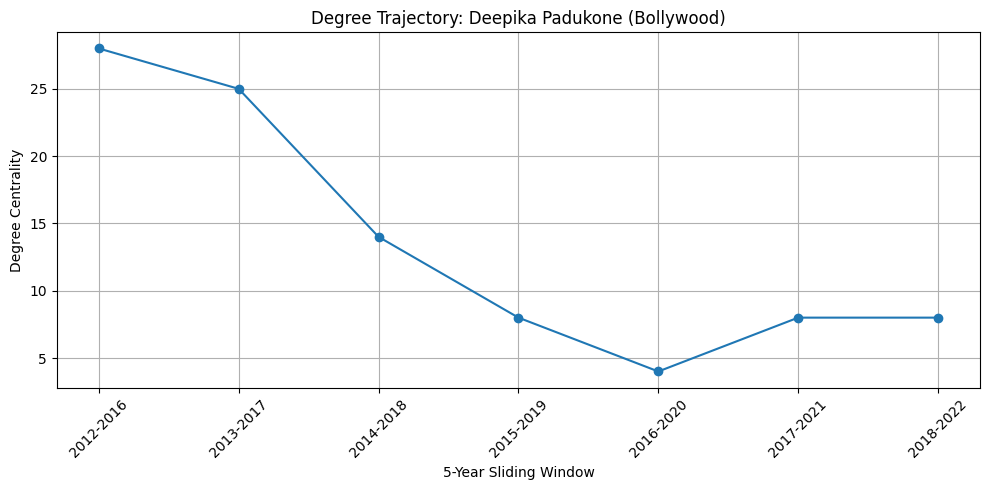

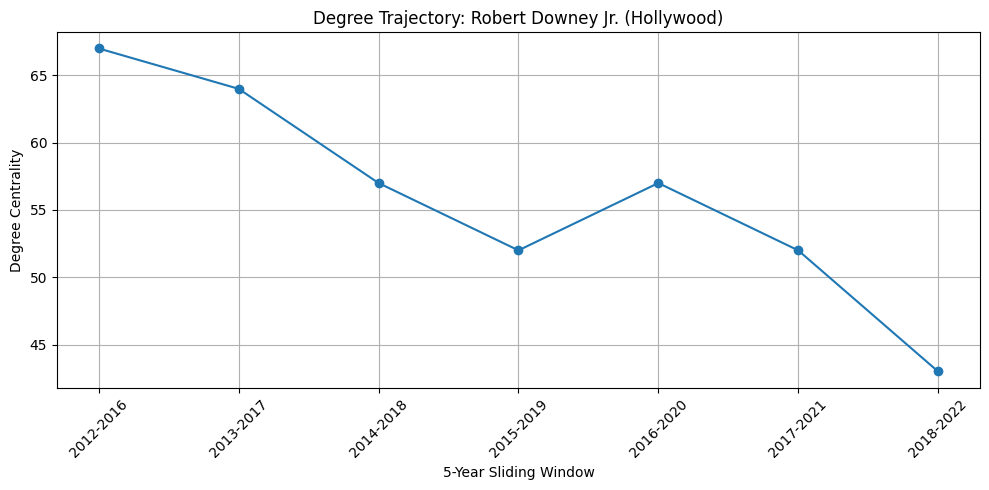

In [13]:
def plot_actor_trajectory(actor_data, actor_name, centrality_label, industry_label):
    if actor_name not in actor_data:
        print(f"No data for {actor_name} in {industry_label}")
        return
    y_values = actor_data[actor_name][centrality_label]
    x_labels = [f"{start}-{end}" for start, end in windows[:len(y_values)]]
    plt.figure(figsize=(10,5))
    plt.plot(x_labels, y_values, marker='o')
    plt.xticks(rotation=45)
    plt.xlabel('5-Year Sliding Window')
    plt.ylabel(f'{centrality_label.capitalize()} Centrality')
    plt.title(f'{centrality_label.capitalize()} Trajectory: {actor_name} ({industry_label})')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Bollywood example
plot_actor_trajectory(results['Bollywood'], 'Deepika Padukone', 'degree', 'Bollywood')

# Hollywood example
plot_actor_trajectory(results['Hollywood'], 'Robert Downey Jr.', 'degree', 'Hollywood')


The degree trajectory plots for Deepika Padukone (Bollywood) and Robert Downey Jr. (Hollywood) reveal distinct patterns in each actor’s evolving network prominence over time. For Deepika Padukone, degree centrality starts at a relatively high level in the early 2010s but shows a consistent decline across subsequent sliding windows, reaching its lowest point around 2016–2020 before stabilizing at a lower level. This trend suggests that while she was highly connected and collaborated with many co-stars early in the observed period, her network breadth contracted over time, possibly reflecting more selective collaborations or changes in her industry role.

Robert Downey Jr.’s trajectory also begins with high degree centrality, indicating a broad and active co-actor network in the early windows. However, while there is a general downward trend similar to Deepika Padukone, the decline is less steep, and there is a noticeable mid-period uptick around 2016–2020. This mid-period boost may reflect participation in ensemble casts or major franchise films that temporarily expanded his collaboration network. By the last window (2018–2022), his degree centrality drops more sharply, potentially aligning with a reduction in collaborative film projects or focusing on solo endeavors.

Overall, both trajectories illustrate how career stages and strategic project choices can lead to dynamic changes in an actor’s network position. High early-career centrality often reflects rapid industry engagement or rising stardom, while subsequent declines may indicate a transition to selective, high-profile roles or a shift in career focus. This reinforces the value of network analysis for understanding the interplay between collaboration patterns and career evolution in the film industry.

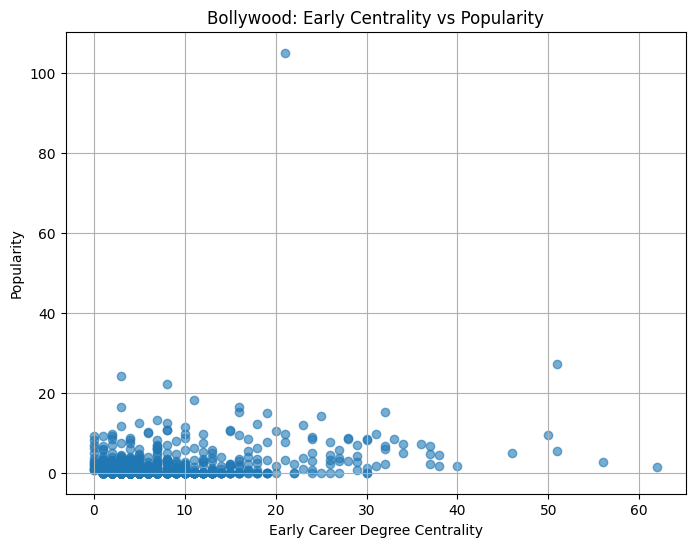

In [14]:

import pandas as pd

def early_vs_career_success(results_dict, career_summary, centrality_label, first_n=1, last_n=1):
    """
    Compute early and late career average centrality scores and combine with career success measure.

    Parameters:
    - results_dict: Dict of actor → metrics list (centrality values over time).
    - career_summary: Pandas Series mapping actor to a career success metric (popularity, movie count, etc).
    - centrality_label: String specifying which centrality metric to analyze (e.g., 'degree').
    - first_n: Number of earliest windows to average for early career centrality.
    - last_n: Number of latest windows to average for late career centrality.

    Returns:
    - DataFrame with columns ['actor', 'early_centrality', 'late_centrality', 'total_movies_or_popularity']
    """
    data = []
    for actor, vals in results_dict.items():
        centr_values = vals.get(centrality_label, [])
        if len(centr_values) >= first_n + last_n:
            early_avg = sum(centr_values[:first_n]) / first_n
            late_avg = sum(centr_values[-last_n:]) / last_n
            success_metric = career_summary.get(actor, 0)
            data.append((actor, early_avg, late_avg, success_metric))
    df = pd.DataFrame(data, columns=['actor', 'early_centrality', 'late_centrality', 'career_success'])
    return df



# Extract Bollywood movies with one main actor per row (e.g., the FIRST actor in 'Cast')
df_bollywood = df[df['original_language'] == 'hi'].copy()
df_bollywood['main_actor'] = df_bollywood['Cast'].apply(lambda x: x[0].strip() if isinstance(x, list) and x else None)

# If each (main actor, movie) combo should count, take the max popularity per actor (or mean, median, etc)
popularity_series = df_bollywood.groupby('main_actor')['popularity'].max()  # or use .mean()/.sum()

df_bollywood_centrality = early_vs_career_success(
    results['Bollywood'],
    popularity_series,
    centrality_label='degree'
)

plt.figure(figsize=(8, 6))
plt.scatter(df_bollywood_centrality['early_centrality'], df_bollywood_centrality['career_success'], alpha=0.6)
plt.xlabel('Early Career Degree Centrality')
plt.ylabel('Popularity')
plt.title('Bollywood: Early Centrality vs Popularity')
plt.grid(True)
plt.show()





This scatter plot examines the relationship between actors’ early career degree centrality—an indicator of their network connectedness at the beginning of their careers—and their eventual popularity. Most data points are concentrated at the lower end of both axes, showing that the majority of actors in the dataset started with modest centrality and remained at a relatively low level of popularity. There are a few notable outliers, like a small number of actors who achieved exceptionally high popularity even when their early centrality was not among the highest, suggesting that while collaborative network position is important, other factors—such as individual performance, star power, or unique opportunities—can play a decisive role in determining popularity.

Additionally, the broad spread and lack of a clear upward trend indicate that there is not a strict linear relationship between early network centrality and later popularity among Bollywood actors. Some with high early centrality do not necessarily rise to the highest popularity, while some achieve high popularity without unusually high centrality in the early phase. This pattern highlights the multifaceted nature of career success in the film industry: while early connectedness might provide opportunities and visibility, sustained popularity is likely affected by diverse factors including talent, public image, and market dynamics. Overall, the plot suggests that network metrics like early degree centrality are only one piece of a more complex puzzle shaping an actor's rise to stardom in Bollywood.

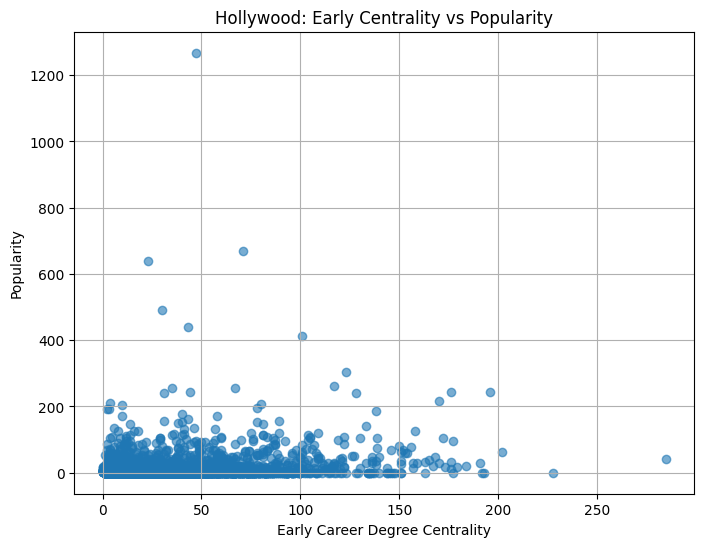

In [15]:
# Extract Hollywood movies with one main actor per row (e.g., the FIRST actor in 'Cast')
df_hollywood = df[df['original_language'] == 'en'].copy()
df_hollywood['main_actor'] = df_hollywood['Cast'].apply(
    lambda x: x[0].strip() if isinstance(x, list) and x else None
)

# Use max popularity per main actor across all movies they appeared in
popularity_series_hollywood = df_hollywood.groupby('main_actor')['popularity'].max()

# Calculate early vs career centrality with this popularity outcome
df_hollywood_centrality = early_vs_career_success(
    results['Hollywood'],
    popularity_series_hollywood,
    centrality_label='degree'
)

# Scatter plot of early degree centrality vs popularity for Hollywood actors
plt.figure(figsize=(8, 6))
plt.scatter(df_hollywood_centrality['early_centrality'], df_hollywood_centrality['career_success'], alpha=0.6)
plt.xlabel('Early Career Degree Centrality')
plt.ylabel('Popularity')
plt.title('Hollywood: Early Centrality vs Popularity')
plt.grid(True)
plt.show()




This scatter plot displays the relationship between an actor’s early career degree centrality within the Hollywood collaboration network and their eventual popularity. The data reveals that the vast majority of Hollywood actors have both low early degree centrality and modest popularity, as evidenced by the dense cluster of points toward the lower left of the graph. However, there are a notable number of actors with high early centrality—some exceeding 200—and similarly several actors with very high popularity scores, with a handful of outliers exhibiting extreme values above 600 and even 1200.

Despite these high-value outliers, the overall distribution displays considerable horizontal and vertical spread, and no strong upward trend. This suggests that while a handful of well-connected actors early in their careers do go on to achieve substantial popularity, high early centrality does not guarantee high popularity, nor is it a prerequisite—some highly popular actors began with relatively low network centrality. The scattered appearance and prevalence of points across the popularity axis for a range of early centrality levels indicate that other factors, beyond early collaborative position, are highly influential in determining Hollywood career success.

Notably, compared to Bollywood, the Hollywood dataset features a broader range of both degree centrality and popularity, possibly reflecting a larger industry scale and greater variation in actor opportunities and career trajectories. In conclusion, while early network embeddedness may provide advantages or visibility, the Hollywood data reinforce the idea that popularity and long-term success are shaped by a complex interplay of network, talent, marketability, and strategic career choices.

# **Milestone 7 — Cross-Industry Comparison and Visualization**

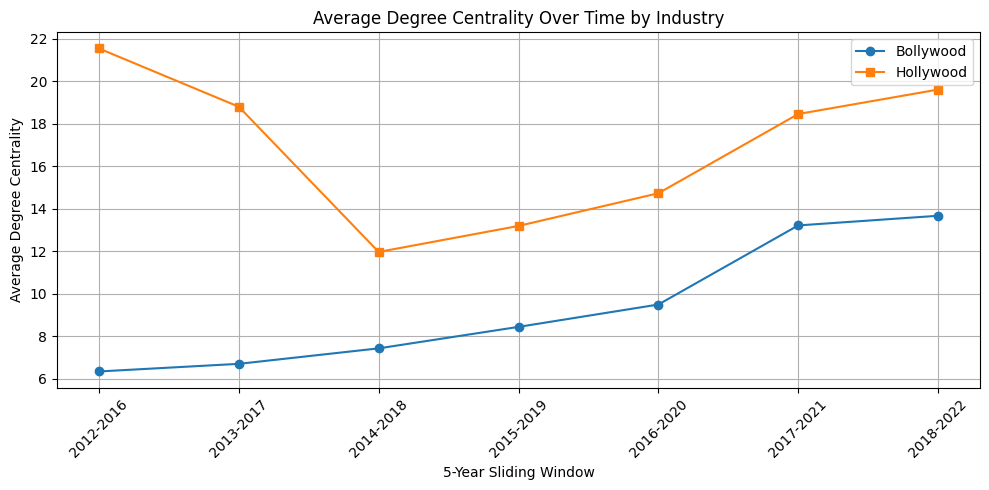

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx



# 1. Compare degree centrality temporal trends averaged over all actors in each industry
def avg_degree_over_time(results_dict, windows):
    avg_deg = []
    for i in range(len(windows)):
        deg_values = []
        for actor, metrics in results_dict.items():
            degrees = metrics.get('degree', [])
            if len(degrees) > i:
                deg_values.append(degrees[i])
        avg_deg.append(sum(deg_values) / len(deg_values) if deg_values else 0)
    return avg_deg

avg_deg_bollywood = avg_degree_over_time(results['Bollywood'], windows)
avg_deg_hollywood = avg_degree_over_time(results['Hollywood'], windows)

window_labels = [f"{start}-{end}" for start, end in windows]

plt.figure(figsize=(10,5))
plt.plot(window_labels, avg_deg_bollywood, marker='o', label='Bollywood')
plt.plot(window_labels, avg_deg_hollywood, marker='s', label='Hollywood')
plt.xticks(rotation=45)
plt.xlabel('5-Year Sliding Window')
plt.ylabel('Average Degree Centrality')
plt.title('Average Degree Centrality Over Time by Industry')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

